In [1]:
import pandas as pd

In [2]:
df_movies = pd.read_csv("../data/ml-100k/movies.csv")
df_ratings = pd.read_csv("../data/ml-100k/ratings.csv")

In [3]:
df_movies = df_movies.drop(columns=["video_release_date", "imdb_url", "movie_id"])
df_movies

,title,release_date,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,Mat' i syn (1997),06-Feb-1998,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,B. Monkey (1998),06-Feb-1998,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,Sliding Doors (1998),01-Jan-1998,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,You So Crazy (1994),01-Jan-1994,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('bert-base-nli-mean-tokens')

In [5]:
sentence_embeddings = bert.encode(df_movies["title"].tolist())
sentence_embeddings

array([[-0.53233075, -0.3486224 ,  1.5046365 , ...,  0.55551976,
         1.2750355 ,  0.5828103 ],
       [-0.13380893,  0.3276669 ,  0.9319807 , ...,  0.23054303,
         1.3567761 ,  0.15365295],
       [-0.3731663 ,  0.32797495,  2.0284822 , ...,  0.5510755 ,
         1.356007  ,  0.38586274],
       ...,
       [-0.46950492,  0.18303928,  1.9074209 , ...,  0.41255704,
         0.9544273 ,  0.41086262],
       [ 0.33231786,  0.3561219 ,  1.4011838 , ..., -0.63218135,
         0.47800708,  0.51150614],
       [-0.01005441,  0.74444216,  0.12918845, ..., -0.1986926 ,
         0.1219803 , -0.08615844]], dtype=float32)

In [16]:
sentence_embeddings.shape

(1682, 768)

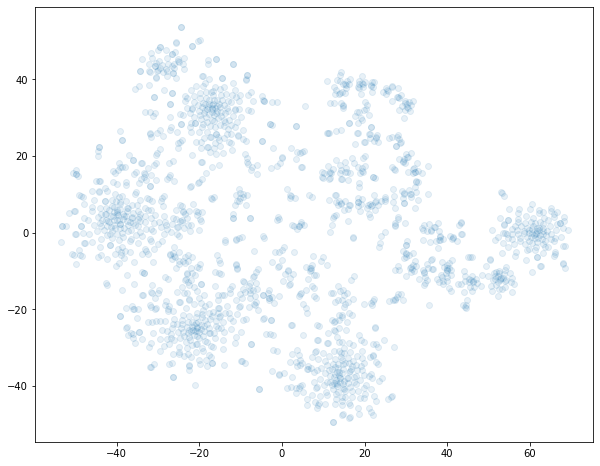

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(sentence_embeddings)
# Add to dataframe for convenience
df_movies['x'] = embs[:, 0]
df_movies['y'] = embs[:, 1]

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
fig.patch.set_facecolor("white")
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df_movies.x, df_movies.y, alpha=.1)

In [20]:
def plot_bg(bg_alpha=.01, figsize=(13, 9), emb_2d=None):
    """Create and return a plot of all our movie embeddings with very low opacity.
    (Intended to be used as a basis for further - more prominent - plotting of a 
    subset of movies. Having the overall shape of the map space in the background is
    useful for context.)
    """
    if emb_2d is None:
        emb_2d = embs
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor("white")
    X = emb_2d[:, 0]
    Y = emb_2d[:, 1]
    ax.scatter(X, Y, alpha=bg_alpha)
    return ax
    
def plot_with_annotations(label_indices, text=True, labels=None, alpha=1, **kwargs):
    ax = plot_bg(**kwargs)
    Xlabeled = embs[label_indices, 0]
    Ylabeled = embs[label_indices, 1]
    if labels is not None:
        for x, y, label in zip(Xlabeled, Ylabeled, labels):
            ax.scatter(x, y, alpha=alpha, label=label, marker='1',
                       s=90,
                      )
        fig.legend()
    else:
        ax.scatter(Xlabeled, Ylabeled, alpha=alpha, color='green')
    
    
    return ax

<AxesSubplot:>

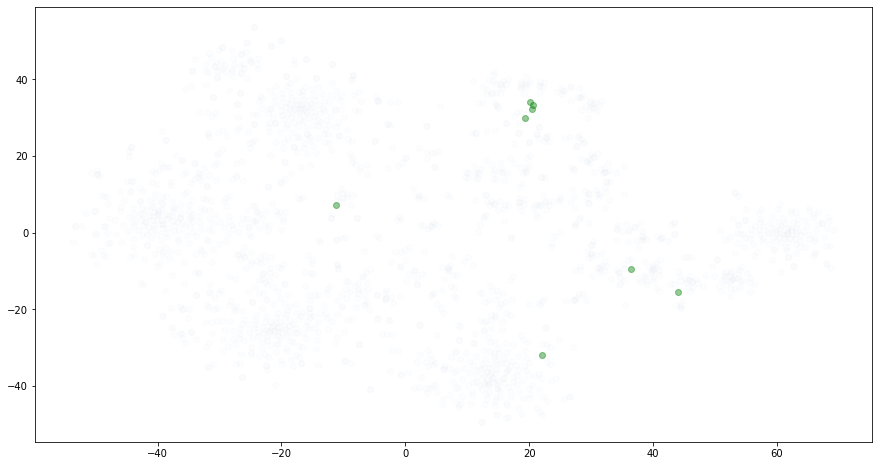

In [21]:
plot_with_annotations(df_movies[df_movies["title"].str.startswith('Star Trek')].index, text=False, alpha=.4, figsize=(15, 8))

In [25]:
def _single_list_similarity(predicted, feature_df):
    recs_content = feature_df[predicted]
    recs_content = recs_content
    similarity = cosine_similarity(X=recs_content, dense_output=False)

    # #get indicies for upper right triangle w/o diagonal
    upper_right = np.triu_indices(similarity.shape[0], k=1)
    upper_right

    # #calculate average similarity score of all recommended items in list
    ils_single_user = np.mean(similarity[upper_right])
    return ils_single_user

_single_list_similarity(df_movies[df_movies["title"].str.startswith('Star Trek')].index.values, sentence_embeddings)

0.703971

In [40]:
df_movies[df_movies["title"].str.startswith('Star Trek')]#.index.values

,title,release_date,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,x,y
221,Star Trek: First Contact (1996),22-Nov-1996,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,-11.258755,7.302514
226,Star Trek VI: The Undiscovered Country (1991),01-Jan-1991,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,43.971485,-15.532055
227,Star Trek: The Wrath of Khan (1982),01-Jan-1982,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,20.090086,34.238033
228,Star Trek III: The Search for Spock (1984),01-Jan-1984,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,20.573278,33.448856
229,Star Trek IV: The Voyage Home (1986),01-Jan-1986,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,20.375870,32.244656
379,Star Trek: Generations (1994),01-Jan-1994,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,22.119844,-32.006802
448,Star Trek: The Motion Picture (1979),01-Jan-1979,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,19.254372,30.050232
449,Star Trek V: The Final Frontier (1989),01-Jan-1989,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,36.497658,-9.542276


In [17]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(sentence_embeddings)

# #get indicies for upper right triangle w/o diagonal
upper_right = np.triu_indices(similarity.shape[0], k=1)
upper_right

# #calculate average similarity score of all recommended items in list
ils_single_user = np.mean(similarity[upper_right])
ils_single_user

0.5074431

In [27]:
df_movies

,title,release_date,unknown,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,x,y
0,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,-30.699291,-17.129539
1,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,-26.447220,-20.510693
2,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,-29.495293,-27.644417
3,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,-14.632439,-16.220663
4,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,-13.733143,-20.936172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,Mat' i syn (1997),06-Feb-1998,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-18.700956,32.102119
1678,B. Monkey (1998),06-Feb-1998,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,11.166046,26.058266
1679,Sliding Doors (1998),01-Jan-1998,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,-26.452583,41.624218
1680,You So Crazy (1994),01-Jan-1994,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,8.885022,-24.399900


In [33]:
df = df_movies.drop(columns=["title", "release_date", "x", "y"])
embs = df.values

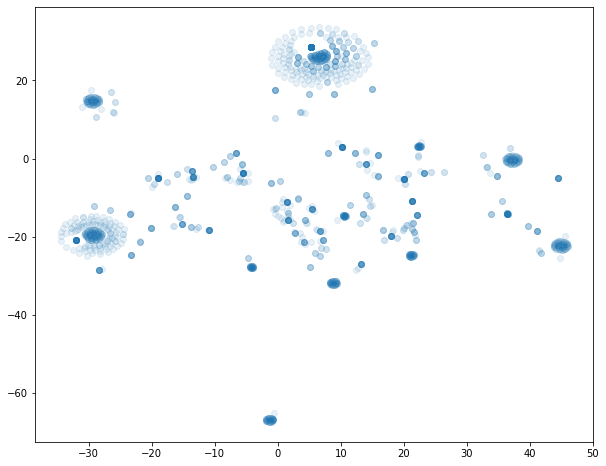

In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(random_state=1, n_iter=15000, metric="cosine")

embs = tsne.fit_transform(df.values)
# Add to dataframe for convenience
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]

FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
fig.patch.set_facecolor("white")
# Make points translucent so we can visually identify regions with a high density of overlapping points
ax.scatter(df.x, df.y, alpha=.1)

<AxesSubplot:>

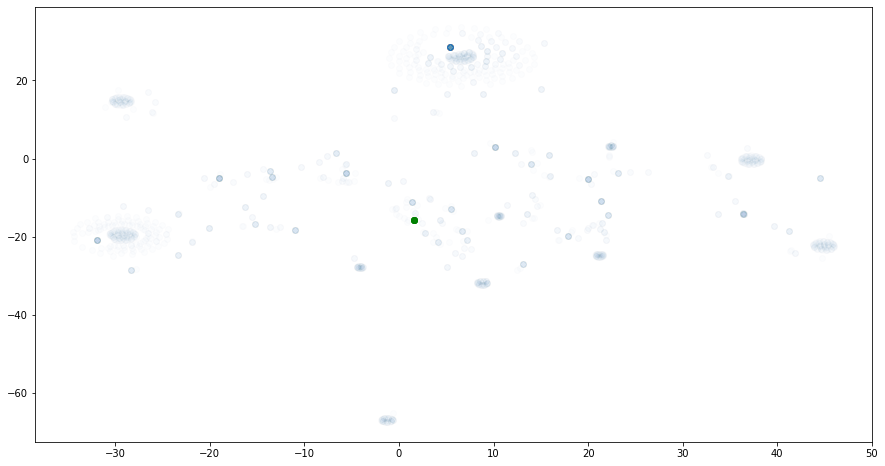

In [35]:
plot_with_annotations(df_movies[df_movies["title"].str.startswith('Star Trek')].index, text=False, alpha=.4, figsize=(15, 8))

In [36]:
_single_list_similarity(df_movies[df_movies["title"].str.startswith('Star Trek')].index.values, embs)

1.0

In [38]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(X=embs, dense_output=False)

# #get indicies for upper right triangle w/o diagonal
upper_right = np.triu_indices(similarity.shape[0], k=1)
upper_right

# #calculate average similarity score of all recommended items in list
ils_single_user = np.mean(similarity[upper_right])
ils_single_user

0.025799703